In [208]:
import numpy as np
import time
from sklearn.metrics import accuracy_score
import scipy.optimize as optim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import calibration
import pandas as pd
from numpy import mean, std
from time import time
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

#### Data cleaning

In [209]:
#load data
df_raw =pd.read_csv('https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv')
df_raw.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [210]:
#calculate days in jail for each individual
df_raw['day_stayed'] = (pd.to_datetime(df_raw["c_jail_out"]) - pd.to_datetime(df_raw["c_jail_in"])).astype('timedelta64[h]') / 24
df_raw = df_raw[df_raw.day_stayed > 0]

In [211]:
#initial selection of the variable to include
#drop those unnecessary variables, eg id, name, first, etc
#drop those that have repeated infor, eg dob (relation to age,age_cat)
df_ini=df_raw.filter(items=['sex','age','age_cat',  'race', 'decile_score','score_text', 'priors_count','days_b_screening_arrest',
                    'v_decile_score', 'v_score_text','c_charge_degree', 'is_violent_recid', 'is_recid', 'day_stayed', 'two_year_recid'])
#

df_ini.head(5)

,sex,age,age_cat,race,decile_score,score_text,priors_count,days_b_screening_arrest,v_decile_score,v_score_text,c_charge_degree,is_violent_recid,is_recid,day_stayed,two_year_recid
0,Male,69,Greater than 45,Other,1,Low,0,-1.0,1,Low,F,0,0,0.958333,0
1,Male,34,25 - 45,African-American,3,Low,0,-1.0,1,Low,F,1,1,10.041667,1
2,Male,24,Less than 25,African-American,4,Low,4,-1.0,3,Low,F,0,1,1.083333,1
5,Male,44,25 - 45,Other,1,Low,0,0.0,1,Low,M,0,0,1.291667,0
6,Male,41,25 - 45,Caucasian,6,Medium,14,-1.0,2,Low,F,0,1,6.291667,1


In [212]:
#df_ini.race.value_counts() --> not all are AA or Caucasian
#drop those that are not
is_race = [i=='African-American' or i=='Caucasian' for i in df_ini.race]
df_ini = df_ini.loc[is_race]
df_ini.race.value_counts()
#df_ini.head(5)

African-American    3417
Caucasian           2282
Name: race, dtype: int64

In [213]:
df_ini['sex'].replace(['Male','Female'],[1,0], inplace = True)
df_ini['race'].replace(['Caucasian','African-American'],[1,0], inplace = True)
df_ini['score_text'].replace(['Low','Medium','High'], [0,1,2], inplace = True)
df_ini['v_score_text'].replace(['Low','Medium','High'], [0,1,2], inplace = True)
df_ini['age_cat'].replace(['Less than 25','25 - 45','Greater than 45'],[0,1,2],inplace = True) 
df_ini['c_charge_degree'].replace(['M','F'],[1,0], inplace = True)
df_ini.head(5)

,sex,age,age_cat,race,decile_score,score_text,priors_count,days_b_screening_arrest,v_decile_score,v_score_text,c_charge_degree,is_violent_recid,is_recid,day_stayed,two_year_recid
1,1,34,1,0,3,0,0,-1.0,1,0,0,1,1,10.041667,1
2,1,24,0,0,4,0,4,-1.0,3,0,0,0,1,1.083333,1
6,1,41,1,1,6,1,14,-1.0,2,0,0,0,1,6.291667,1
8,0,39,1,1,1,0,0,-1.0,1,0,1,0,0,2.916667,0
9,1,21,0,1,3,0,1,428.0,5,1,0,1,1,0.958333,1


Correlation with the target variable:
sex                        0.098285
age                       -0.185869
age_cat                   -0.155043
race                      -0.123671
decile_score               0.366421
score_text                 0.339302
priors_count               0.274079
days_b_screening_arrest    0.026153
v_decile_score             0.299627
v_score_text               0.255516
c_charge_degree           -0.098621
is_violent_recid           0.346080
is_recid                   0.937775
day_stayed                 0.116030
two_year_recid             1.000000
Name: two_year_recid, dtype: float64


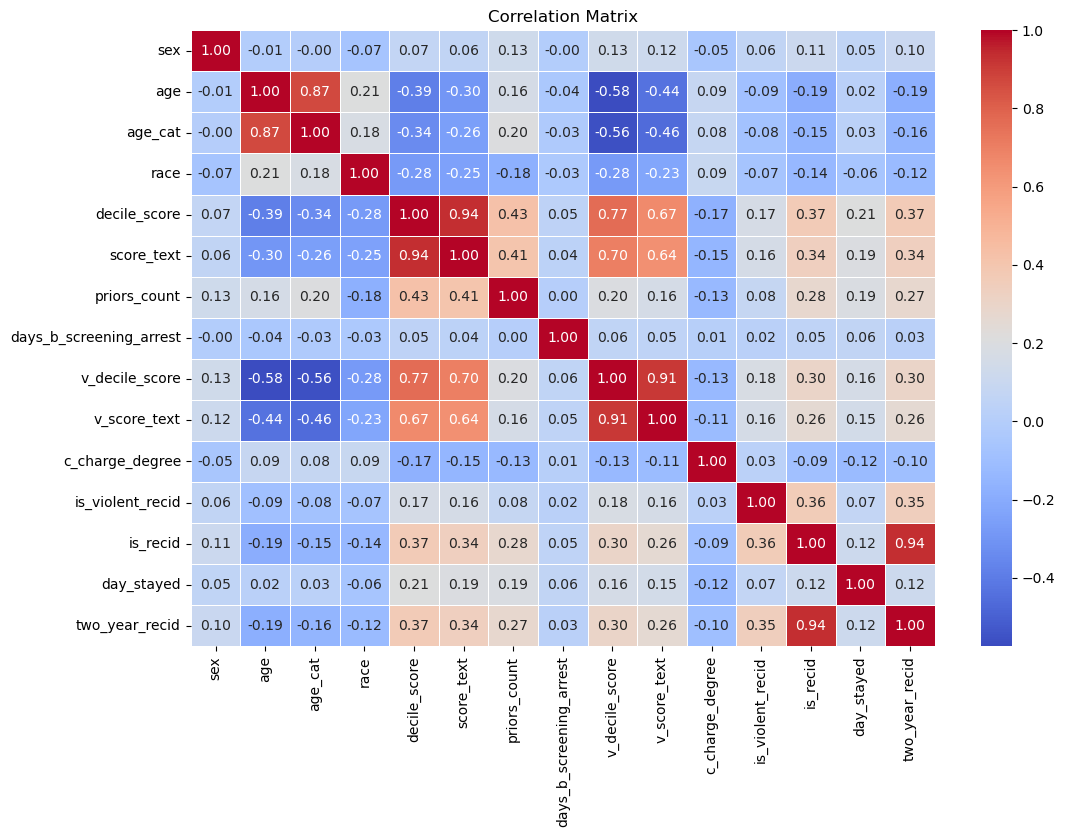

In [214]:
# Assuming you have a DataFrame 'df' with your data
# df = pd.read_csv('your_data.csv')

# Get the list of column names
column_names = df_ini.columns.tolist()

# Assuming 'target_variable' is the name of your target variable
target_variable = 'two_year_recid'

# Select relevant features for correlation analysis
features_for_correlation = column_names.copy()  # Copy the list of column names
features_for_correlation.remove(target_variable)

# Calculate the correlation matrix
correlation_matrix = df_ini[features_for_correlation + [target_variable]].corr()

# Extract correlations with the target variable
correlations_with_target = correlation_matrix[target_variable]

# Print or visualize correlations
print("Correlation with the target variable:")
print(correlations_with_target)

# You can also visualize the entire correlation matrix using a heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


In [215]:
# Example: Remove one of the highly correlated features
threshold = 0.4  # Set your correlation threshold

# Find pairs of highly correlated features
highly_correlated_pairs = [(i, j) for i in range(len(correlation_matrix.columns))
                           for j in range(i+1, len(correlation_matrix.columns))
                           if abs(correlation_matrix.iloc[i, j]) > threshold]

# Remove one feature from each highly correlated pair
features_to_remove = set()
for i, j in highly_correlated_pairs:
    feature_i = correlation_matrix.columns[i]
    feature_j = correlation_matrix.columns[j]
    
    # Keep the feature with higher correlation with the target variable
    if abs(correlations_with_target[feature_i]) > abs(correlations_with_target[feature_j]):
        features_to_remove.add(feature_j)
    else:
        features_to_remove.add(feature_i)

# Drop the identified features
df = df_ini.drop(columns=features_to_remove)
df.head(5)

,sex,race,decile_score,days_b_screening_arrest,c_charge_degree,is_violent_recid,day_stayed,two_year_recid
1,1,0,3,-1.0,0,1,10.041667,1
2,1,0,4,-1.0,0,0,1.083333,1
6,1,1,6,-1.0,0,0,6.291667,1
8,0,1,1,-1.0,1,0,2.916667,0
9,1,1,3,428.0,0,1,0.958333,1


d is a distance measure on X, simple Euclidean distance:
$$d(x_n, v_k) = ||x_n − v_k||_2$$
To allow different input features to have different levels of impace, we add $α_i$ to introduce individual weight parameters for each feature dimension. 
$$d(x_n, v_k, α) = \sum\limits _{i=1}^{D} α_i(x_{ni} - v_{ki})^2$$

In [216]:
from numba import jit
@jit
def distances(X, v, alpha, N, P, k):
    dists = np.zeros((N, P))
    for i in range(N):
        for p in range(P):
            for j in range(k):    
                dists[i, j] += (X[i, p] - v[j, p]) * (X[i, p] - v[j, p]) * alpha[p]
    return dists

/var/folders/_y/30qs0jz17rz4wnknc7dm4rcr0000gn/T/ipykernel_9263/3660324205.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


$M_{n,k}$ as the probability that $x_n$ maps to $v_k$:
$$M_{n,k}=P(Z=k|x_n)\;\forall n,k$$
When the algorithms maps the original dataset $X$ to prototypes, the infomation that whether or not the individual belongs to protected group are removed. To achieve this, formula of statistical parity are used:
$$P(Z=k|x^+ \in X^+) = P(Z=k|x^- \in X^-)\;\forall k$$
(a discriminative clustering model, where the prototypes act as the clusters)

A set of prototypes induces a natural probabilistic mapping from $X$ to $Z$ via the softmax:
$$P(Z=k|x)=exp(-d(x,v_k))/\sum\limits_{j=1}^{k}exp(-d(x,v_j))$$

In [217]:
@jit
def M_nk(dists, N, k):
    M_nk = np.zeros((N, k))
    exp = np.zeros((N, k))
    denom = np.zeros(N)
    for i in range(N):
        for j in range(k):
            exp[i, j] = np.exp(-1 * dists[i, j])
            denom[i] += exp[i, j]
        for j in range(k):
            if denom[i]:
                M_nk[i, j] = exp[i, j] / denom[i]
            else:
                M_nk[i, j] = exp[i, j] / 1e-6
    return M_nk

/var/folders/_y/30qs0jz17rz4wnknc7dm4rcr0000gn/T/ipykernel_9263/2771268032.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


To ensure statistical parity, ensure equation 1 by using training data as:
$$M_k^+ = M_k^- \; \forall k$$
$$M^+_k = \frac{1}{|X^+_0|} \sum_{n \in X^+_0} M_{n,k} = \mathbb{E}_{x \in X^+}P(Z=k|x)$$
$M^-_k$ is defined similarly.

In [218]:
@jit
def M_k(M_nk, N, k):
    M_k = np.zeros(k)
    for j in range(k):
        for i in range(N):
            M_k[j] += M_nk[i, j]
        M_k[j] /= N
    return M_k

/var/folders/_y/30qs0jz17rz4wnknc7dm4rcr0000gn/T/ipykernel_9263/442650194.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


First  term in objective:
$$L_z = \sum_{k=1}^K |M_k^+ - M_k^-| $$
Second term quantify the amount of information lost in the new representation using a simple squared-error measure:
$$L_x = \sum_{n=1}^N (x_n - \hat{x}_n)^2$$
where $ \hat{x}_n $ are the reconstructions of $x_n$ from $Z$:
$$\hat{x}_n = \sum^K_{k=1}M_{nk}v_k$$
These first two terms encourage the system to encode all information in the input attributes except for those that can lead to biased decisions.
Third term requires the prediction of $y$ is as accurate as possible:
$$L_y = \sum_{n=1}^N -y_n log \hat{y}_n - (1-y_n)log(1- \hat{y}_n) $$
Here $\hat{y}_n$ is the prediction for $y_n$,  based on marginalizing over each prototype’s prediction for $Y$, weighted by their respective probabilities $P(Z = k|x_n)$:
$$\hat{y_n}=\sum\limits_{k = 1}^{K}M_{n,k}w_k$$
,we constrain the $w_k$ values to be between 0 and 1.

Ultimate goal is to minimize:
$$L = A_z \cdot L_z + A_x \cdot L_x + A_y \cdot L_y $$

In [219]:
@jit
def x_n_hat(X, M_nk, v, N, P, k):
    x_n_hat = np.zeros((N, P))
    L_x = 0.0
    for i in range(N):
        for p in range(P):
            for j in range(k):
                x_n_hat[i, p] += M_nk[i, j] * v[j, p]
            L_x += (X[i, p] - x_n_hat[i, p]) * (X[i, p] - x_n_hat[i, p])
    return x_n_hat, L_x

def yhat(M_nk, y, w, N, k):
    yhat = np.zeros(N)
    L_y = 0.0
    for i in range(N):
        for j in range(k):
            yhat[i] += M_nk[i, j] * w[j]
        yhat[i] = 1e-6 if yhat[i] <= 0 else yhat[i]
        yhat[i] = 0.999 if yhat[i] >= 1 else yhat[i]
        L_y += -1 * y[i] * np.log(yhat[i]) - (1.0 - y[i]) * np.log(1.0 - yhat[i])
    return yhat, L_y

def LFR(params, data_sensitive, data_nonsensitive, y_sensitive, y_nonsensitive,  k=10, A_x = 1e-4, A_y = 0.1, A_z = 1000, results=0):
    
    LFR.iters += 1 
    Ns, P = data_sensitive.shape
    Nns, _ = data_nonsensitive.shape
    
    alpha0 = params[:P]
    alpha1 = params[P : 2 * P]
    w = params[2 * P : (2 * P) + k]
    v = np.matrix(params[(2 * P) + k:]).reshape((k, P))
        
    dists_sensitive = distances(data_sensitive, v, alpha1, Ns, P, k)
    dists_nonsensitive = distances(data_nonsensitive, v, alpha0, Nns, P, k)

    M_nk_sensitive = M_nk(dists_sensitive, Ns, k)
    M_nk_nonsensitive = M_nk(dists_nonsensitive, Nns, k)
    
    M_k_sensitive = M_k(M_nk_sensitive, Ns, k)
    M_k_nonsensitive = M_k(M_nk_nonsensitive, Nns, k)
    
    L_z = 0.0
    for j in range(k):
        L_z += abs(M_k_sensitive[j] - M_k_nonsensitive[j])

    x_n_hat_sensitive, L_x1 = x_n_hat(data_sensitive, M_nk_sensitive, v, Ns, P, k)
    x_n_hat_nonsensitive, L_x2 = x_n_hat(data_nonsensitive, M_nk_nonsensitive, v, Nns, P, k)
    L_x = L_x1 + L_x2

    yhat_sensitive, L_y1 = yhat(M_nk_sensitive, y_sensitive, w, Ns, k)
    yhat_nonsensitive, L_y2 = yhat(M_nk_nonsensitive, y_nonsensitive, w, Nns, k)
    L_y = L_y1 + L_y2

    loss = A_x * L_x + A_y * L_y + A_z * L_z

    if LFR.iters % 500 == 0:
        print("step: {}, loss: {}, L_x: {},  L_y: {},  L_z: {}".format(
            LFR.iters, loss, L_x,  L_y,  L_z))
      
    if results:
        return yhat_sensitive, yhat_nonsensitive, M_nk_sensitive, M_nk_nonsensitive
    else:
        return loss
LFR.iters = 0

/var/folders/_y/30qs0jz17rz4wnknc7dm4rcr0000gn/T/ipykernel_9263/1793627912.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [220]:
# k = number of propotypes
k = 7
data = np.array(df)
y = np.array(data[:,-1]).flatten()
data = data[:,:-1]
sensitive = data[:,1]

data = preprocessing.scale(data)
#data = data[:, :387]
sensitive_idx = np.array(np.where(sensitive==1))[0].flatten()
nonsensitive_idx = np.array(np.where(sensitive!=1))[0].flatten()
data_sensitive = data[sensitive_idx,:]
data_nonsensitive = data[nonsensitive_idx,:]
y_sensitive = y[sensitive_idx]
y_nonsensitive = y[nonsensitive_idx]


In [221]:
#train, val, test for nonsensitive and sensitive data
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
sensitive_train_val, sensitive_test, sensitive_ytrain_val, sensitive_ytest = train_test_split(data_sensitive, y_sensitive, test_size=test_ratio, random_state=42)
sensitive_train, sensitive_val, sensitive_ytrain,  sensitive_yval= train_test_split(sensitive_train_val,sensitive_ytrain_val, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)

nonsensitive_train_val, nonsensitive_test, nonsensitive_ytrain_val, nonsensitive_ytest = train_test_split(data_sensitive, y_sensitive, test_size=test_ratio, random_state=42)
nonsensitive_train, nonsensitive_val, nonsensitive_ytrain,  nonsensitive_yval = train_test_split(nonsensitive_train_val, nonsensitive_ytrain_val, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)

test = np.concatenate((sensitive_test, nonsensitive_test))
ytest = np.concatenate((sensitive_ytest, nonsensitive_ytest))

training = np.concatenate((sensitive_train, nonsensitive_train))
ytrain = np.concatenate((sensitive_ytrain, nonsensitive_ytrain))

In [222]:
rez = np.random.uniform(size=data.shape[1] * 2 + k + data.shape[1] * k)
yhat_sensitive, yhat_nonsensitive, M_nk_sensitive, M_nk_nonsensitive = LFR(rez,
                                                                           sensitive_train,
                                                                           nonsensitive_train,
                                                                           sensitive_ytrain,
                                                                           nonsensitive_ytrain,
                                                                           k, 1e-4, 0.1, 1000,
                                                                           results=1)

val_yhat_sensitive, val_yhat_nonsensitive, val_M_nk_sensitive, val_M_nk_nonsensitive = LFR(rez,
                                                                           sensitive_val,
                                                                           nonsensitive_val,
                                                                           sensitive_yval,
                                                                           nonsensitive_yval,
                                                                           k, 1e-4, 0.1, 1000,
                                                                            results = 1)

In [223]:
bnd = []
for i, k2 in enumerate(rez):
    if i < data.shape[1] * 2 or i >= data.shape[1] * 2 + k:
        bnd.append((None, None))
    else:
        bnd.append((0, 1))
start = time()
rez = optim.fmin_l_bfgs_b(LFR, x0=rez, epsilon=1e-5,
                          args=(sensitive_train,
                                nonsensitive_train,
                                sensitive_ytrain,
                                nonsensitive_ytrain, k, 1e-4,
                                0.1, 1000, 0),
                          bounds = bnd, approx_grad=True, maxfun=10000,
                          maxiter=10000, iprint=-1)
end= time()

step: 500, loss: 293.0778410343131, L_x: 24745.51469028119,  L_y: 2406.609953431519,  L_z: 0.0499422942221331
step: 1000, loss: 251.75262812010527, L_x: 24763.771407205648,  L_y: 2318.621504911313,  L_z: 0.01741410048825341
step: 1500, loss: 236.29658413696146, L_x: 24704.31939268574,  L_y: 2274.0637836730666,  L_z: 0.006419773830386222
step: 2000, loss: 232.27158826528856, L_x: 24690.82349748113,  L_y: 2258.943123790684,  L_z: 0.0039081935364720655
step: 2500, loss: 226.19098910765499, L_x: 24627.939681022042,  L_y: 2200.761793919731,  L_z: 0.0036520157475796317
step: 3000, loss: 211.96431378872154, L_x: 24199.88899228973,  L_y: 2074.662407618055,  L_z: 0.002078084127687063
step: 3500, loss: 210.7723244358039, L_x: 24202.839647193206,  L_y: 2074.229268047143,  L_z: 0.0009291136663703153
step: 4000, loss: 210.28925503745967, L_x: 24180.626182741114,  L_y: 2074.093270187946,  L_z: 0.00046186540039094837
step: 4500, loss: 210.03724782537694, L_x: 24199.878080884773,  L_y: 2073.9298595853

In [224]:
print("training time: {}s".format(end-start))

training time: 111.1734368801117s


In [225]:
w = rez[0][data.shape[1]*2:data.shape[1]*2+k]
v = rez[0][data.shape[1]*2+k:].reshape(k,data.shape[1])

In [226]:
test_yhat_sensitive, test_yhat_nonsensitive, test_M_nk_sensitive, test_M_nk_nonsensitive = LFR(rez[0],
                                                                           sensitive_test,
                                                                           nonsensitive_test,
                                                                           sensitive_ytest,
                                                                           nonsensitive_ytest,
                                                                           k, 1e-4, 0.1, 1000,
                                                                            results = 1)

In [227]:
test_yhat_sensitive = [1 if x >=.5 else 0 for x in test_yhat_sensitive]
test_yhat_nonsensitive = [1 if x >=.5 else 0 for x in test_yhat_nonsensitive]

sensitive_accuracy = accuracy_score(list(sensitive_ytest),list(test_yhat_sensitive))
nonsensitive_accuracy = accuracy_score(list(nonsensitive_ytest),list(test_yhat_nonsensitive))
print(f'the test accuracy for for sensitive group is: {sensitive_accuracy}')
print(f'the test accuracy for for nonsensitive group is: {nonsensitive_accuracy}')


the test accuracy for for sensitive group is: 0.6472303206997084
the test accuracy for for nonsensitive group is: 0.6443148688046647


In [228]:
target = list(sensitive_ytest) + list(nonsensitive_ytest)
pred = list(ytest_sensitive_pred) + list(ytest_nonsensitive_pred)
pred = [1 if x >=.5 else 0 for x in pred]
total_accuracy = accuracy_score(target,pred)
print(f'the test accuracy for overall is: {total_accuracy}')

the test accuracy for overall is: 0.6457725947521866
